In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# project_dir = "/codespace/braintypicality"
# sys.path.append(project_dir)

In [2]:
import skimage
import glob
import math
import torch
import ants
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors


from functools import partial

import skimage.filters as skf
# from scipy.stats import percentileofscore
# from numba import jit
# from utils import get_percentile_tensor

In [3]:
from sade.configs.flows import ve_flow_config as configs
config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

### Load the data

In [4]:
config.data.dataset = "ABCD"
config.eval.experiment.train = "abcd-val"
config.eval.experiment.inlier = "abcd-test"
config.eval.experiment.ood = "lesion_load_20-enhanced"
experiment = f"{config.eval.experiment.inlier}_{config.eval.experiment.ood}"
# config.data.image_size = (176, 208, 160)
# config.data.cache_rate = 0.0
# config.data.spacing_pix_dim = 1.0
config.eval.batch_size = 4
config.data

cache_rate: 0.0
dataset: ABCD
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
spacing_pix_dim: 2.0
splits_dir: /codespace/sade/sade/datasets/brains/

In [5]:
# flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg200_nb20_long/eval/ckpt_6040/'
# flow_250k_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg250_long_smin1e-1/eval/ckpt_6640/'
flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg300_smin1e-2_smax0.8/eval/ckpt_9240/'
%ls $flow_path

abcd-test_lesion_load_20-enhanced_results.npz
abcd-test_lesion_load_20-enhanced_seg_eval.csv
abcd-test_lesion_load_20-enhanced_segs.npz
abcd-val_lesion_load_20_results.npz
ibis-hr-inlier_ibis-ds-sa_results.npz
ibis-inlier_ibis-asd_results.npz
ibis-inlier_ibis-atypical_results.npz


In [7]:
flow_metrics = pd.read_csv(f"{flow_path}/{experiment}_seg_eval.csv").dropna()
# flow_250k_metrics = pd.read_csv(f"{flow_250k_path}/{experiment}_seg_eval.csv").dropna()

In [8]:
flow_metrics.describe()

,Unnamed: 0,TP,FP,FN,ground_truth_components,segmentation_components,hausdorff,mean_surf_dist,TPR,FNR,PPV
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,81.765432,10.864198,0.561728,2.166667,13.030864,12.987654,7.046932,2.101743,0.831864,0.168136,0.957291
std,47.979491,4.343205,3.015367,2.406642,4.425256,4.491521,7.763239,5.429535,0.178298,0.178298,0.148825
min,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.236068,0.794885,0.000000,0.000000,0.000000
25%,40.250000,8.000000,0.000000,1.000000,10.000000,10.000000,4.131773,0.955407,0.785714,0.058824,1.000000
50%,81.500000,11.000000,0.000000,2.000000,13.000000,13.000000,5.079710,1.041449,0.861905,0.138095,1.000000
75%,122.750000,14.000000,0.000000,3.000000,16.000000,16.000000,6.928203,1.154730,0.941176,0.214286,1.000000
max,164.000000,22.000000,34.000000,18.000000,26.000000,34.000000,65.785095,42.459126,1.000000,1.000000,1.000000


In [9]:
ae_path = "/ASD/ahsan_projects/anomaly-AE-baseline/20231004_insize96-112-80_z512_denseAE_sigmoid/"
ae_metrics = pd.read_csv(f"{ae_path}/{experiment}_seg_eval.csv").dropna()

gradcam_path = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/msma/gradcam/relu/"
gradcam_metrics = pd.read_csv(f"{gradcam_path}/{experiment}_seg_eval.csv").dropna()

inpaint_path = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/inpainting/"
inpaint_metrics = pd.read_csv(f"{inpaint_path}/{experiment}_seg_eval.csv").dropna()

restoration_path = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/restoration/"
restoration_metrics = pd.read_csv(f"{restoration_path}/{experiment}_seg_eval.csv").dropna()

In [34]:
higher_metric_cols = ["TPR", "PPV"]
lower_metric_cols = ["hausdorff", "mean_surf_dist"]
lower_is_better_metrics, higher_is_better_metrics = [], []
# wide_df = []

for name, m in zip(("AE", "Inpaint", "Restoration", "GradCAM", "Patch-MSMA"),
                   (ae_metrics, inpaint_metrics, restoration_metrics, gradcam_metrics, flow_metrics)):
    
    df = m[lower_metric_cols].melt(var_name="Metric")
    df["Model"] = name
    lower_is_better_metrics.append(df)
    
    df = m[higher_metric_cols].melt(var_name="Metric")
    df["Model"] = name
    higher_is_better_metrics.append(df)
    
#     df = m[wide_df]
    
lower_is_better_metrics = pd.concat(lower_is_better_metrics)
higher_is_better_metrics = pd.concat(higher_is_better_metrics)

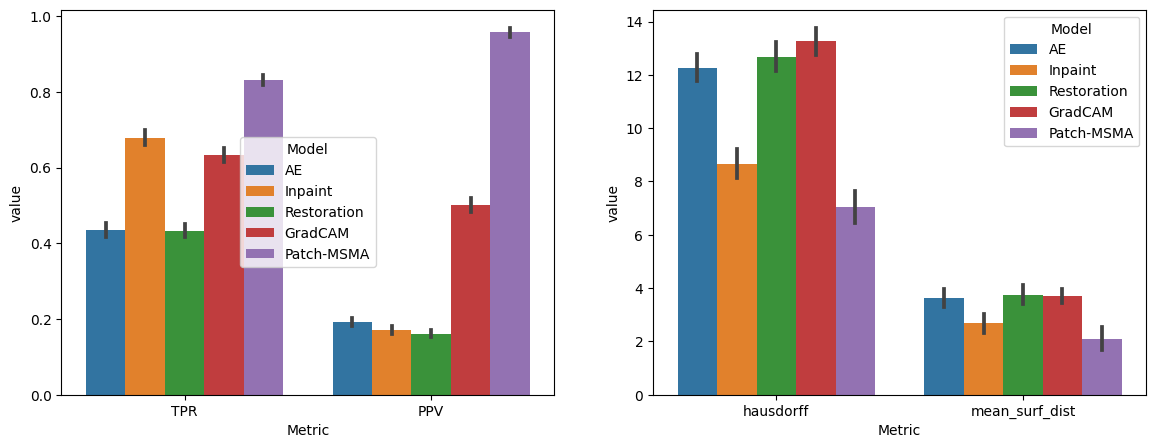

In [35]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
g = sns.barplot(data=higher_is_better_metrics, x="Metric", y="value", hue="Model", errorbar="se", ax =axs[0])
g = sns.barplot(data=lower_is_better_metrics, x="Metric", y="value", hue="Model", errorbar="se", ax =axs[1])
# g.despine(left=True)
# g.legend.set_title("")

In [36]:
d = pd.DataFrame(columns=["TPR", "PPV"])

for name, m in zip(("AE", "GradCAM", "Inpaint", "Restoration", "Spatial-MSMA"),
                   (ae_metrics, gradcam_metrics, inpaint_metrics, restoration_metrics, flow_metrics)):
    stats = m[higher_metric_cols].describe()
    se = (stats.loc["std"] / np.sqrt(m.shape[0])).apply('{:.2f}'.format)
    mu = stats.loc["mean"].apply('{:.2f}'.format)
    text = (mu + " +/- " + se.astype(str)).values
    d.loc[name] = text
d

,TPR,PPV
AE,0.44 +/- 0.02,0.19 +/- 0.01
GradCAM,0.63 +/- 0.02,0.50 +/- 0.02
Inpaint,0.68 +/- 0.02,0.17 +/- 0.01
Restoration,0.43 +/- 0.02,0.16 +/- 0.01
Spatial-MSMA,0.83 +/- 0.01,0.96 +/- 0.01


In [37]:
d = pd.DataFrame(columns=["Hausdorff", "MSD"])

for name, m in zip(("AE", "GradCAM", "Inpaint", "Restoration", "Spatial-MSMA"),
                   (ae_metrics, gradcam_metrics, inpaint_metrics, restoration_metrics, flow_metrics)):
    stats = m[lower_metric_cols].describe()
    se = (stats.loc["std"] / np.sqrt(m.shape[0])).apply('{:.2f}'.format)
    mu = stats.loc["mean"].apply('{:.2f}'.format)
    text = (mu + " +/- " + se.astype(str)).values
    d.loc[name] = text
d

,Hausdorff,MSD
AE,12.27 +/- 0.51,3.63 +/- 0.35
GradCAM,13.26 +/- 0.50,3.71 +/- 0.27
Inpaint,8.67 +/- 0.53,2.68 +/- 0.36
Restoration,12.68 +/- 0.54,3.75 +/- 0.37
Spatial-MSMA,7.05 +/- 0.61,2.10 +/- 0.43


In [38]:
f"\textbf{{{text}}}" 

"\textbf{['7.05 +/- 0.61' '2.10 +/- 0.43']}"

In [41]:
d = pd.DataFrame(columns=["Hausdorff", "MSD", "TPR", "PPV"])

for name, m in zip(("AE", "Inpaint", "Restoration", "GradCAM-MSMA", "Spatial-MSMA"),
                   (ae_metrics, gradcam_metrics, inpaint_metrics, restoration_metrics, flow_metrics)):
    stats = m[lower_metric_cols+higher_metric_cols].describe()
    se = (stats.loc["std"] / np.sqrt(m.shape[0])).apply('{:.2f}'.format)
    mu = stats.loc["mean"].apply('{:.2f}'.format)
    text = (mu + "$\pm$~" + se.astype(str)).values
    d.loc[name] = text
d

,Hausdorff,MSD,TPR,PPV
AE,12.27$\pm$~0.51,3.63$\pm$~0.35,0.44$\pm$~0.02,0.19$\pm$~0.01
Inpaint,13.26$\pm$~0.50,3.71$\pm$~0.27,0.63$\pm$~0.02,0.50$\pm$~0.02
Restoration,8.67$\pm$~0.53,2.68$\pm$~0.36,0.68$\pm$~0.02,0.17$\pm$~0.01
GradCAM-MSMA,12.68$\pm$~0.54,3.75$\pm$~0.37,0.43$\pm$~0.02,0.16$\pm$~0.01
Spatial-MSMA,7.05$\pm$~0.61,2.10$\pm$~0.43,0.83$\pm$~0.01,0.96$\pm$~0.01


In [42]:
print(d.to_latex(index=True, header=True, column_format='lccc', escape=False))

\begin{tabular}{lccc}
\toprule
{} &        Hausdorff &             MSD &             TPR &             PPV \\
\midrule
AE           &  12.27$\pm$~0.51 &  3.63$\pm$~0.35 &  0.44$\pm$~0.02 &  0.19$\pm$~0.01 \\
Inpaint      &  13.26$\pm$~0.50 &  3.71$\pm$~0.27 &  0.63$\pm$~0.02 &  0.50$\pm$~0.02 \\
Restoration  &   8.67$\pm$~0.53 &  2.68$\pm$~0.36 &  0.68$\pm$~0.02 &  0.17$\pm$~0.01 \\
GradCAM-MSMA &  12.68$\pm$~0.54 &  3.75$\pm$~0.37 &  0.43$\pm$~0.02 &  0.16$\pm$~0.01 \\
Spatial-MSMA &   7.05$\pm$~0.61 &  2.10$\pm$~0.43 &  0.83$\pm$~0.01 &  0.96$\pm$~0.01 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_38540/207577648.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [ ]:
# %%latex

# \begin{tabular}{lccc}
# \toprule
# {} &  hausdorff &  mean_surf_dist \\
# \midrule
# AE         &  12.272418 &        3.625731 \\
# GradCAM    &  12.751333 &        4.462771 \\
# Patch-MSMA &   9.274731 &        2.246507 \\
# \bottomrule
# \end{tabular}